# Notebook to extract hidden-states and attention heads activations from bert model predictions

In [11]:
import os
import glob
import torch
import gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import BertExtractor
from sklearn.preprocessing import StandardScaler
from tokenizer import tokenize
from utils import set_seed
from numpy import linalg as la

In [12]:
def check_folder(path):
    """Create adequate folders if necessary."""
    try:
        if not os.path.isdir(path):
            check_folder(os.path.dirname(path))
            os.mkdir(path)
    except:
        pass

In [13]:
def transform(activations, path, name, run_index, n_layers_hidden=13, n_layers_attention=12, hidden_size=768):
    assert activations.values.shape[1] == (n_layers_hidden + n_layers_attention) * hidden_size
    indexes = [[index*hidden_size, (index+1)*hidden_size] for index in range(n_layers_hidden + n_layers_attention)]
    for order in [None]:
        matrices = []
        for index in indexes:
            matrix = activations.values[:, index[0]:index[1]]
            with_std = True if order=='std' else False
            scaler = StandardScaler(with_mean=True, with_std=with_std)
            scaler.fit(matrix)
            matrix = scaler.transform(matrix)
            if order is not None and order != 'std':
                matrix = matrix / np.mean(la.norm(matrix, ord=order, axis=1))
            matrices.append(matrix)
        matrices = np.hstack(matrices)
        new_data = pd.DataFrame(matrices, columns=activations.columns)
        new_path = path + '_norm-' + str(order).replace('np.', '')
        check_folder(new_path)
        new_data.to_csv(os.path.join(new_path, name + '_run{}.csv'.format(run_index + 1)), index=False)


Defining variables:

In [14]:
template = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/text/english/text_english_run*.txt' # path to text input
language = 'english'

Creating iterator for each run:

In [15]:
#template = '/Users/alexpsq/Code/Parietal/data/text_english_run*.txt' # path to text input


In [16]:
paths = sorted(glob.glob(template))

In [17]:
iterator_list = [tokenize(path, language, train=False) for path in paths]

100%|██████████| 207/207 [00:00<00:00, 79785.05it/s]


[32, 38, 41, 43, 43, 43, 43, 44, 45, 45, 45, 47, 47, 48, 48, 49, 49, 50, 51, 51, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 64, 65, 66, 66, 67, 68, 69, 69, 70, 70, 71, 71, 72, 74, 74, 75, 75, 76, 76, 76, 78, 78, 79, 79, 80, 81, 81, 82, 83, 85, 85, 87, 87, 87, 88, 89, 90, 90, 90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 95, 95, 95, 95, 95, 96, 97, 97, 97, 97, 97, 97, 98, 98, 98, 99, 100, 101, 101, 102, 102, 102, 103, 103, 103, 103, 105, 105, 105, 106, 106, 106, 107, 108, 109, 110, 111, 111, 112, 112, 113, 113, 115, 115, 117, 117, 120, 120, 122, 123, 124, 126, 127]


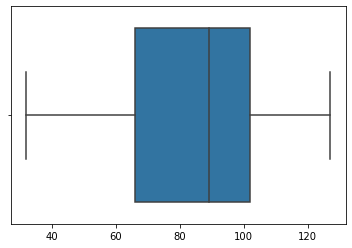


[44, 46, 47, 48, 51, 57, 57, 58, 59, 59, 59, 60, 61, 62, 62, 62, 63, 64, 64, 65, 66, 67, 69, 72, 72, 72, 73, 73, 73, 75, 76, 76, 77, 78, 79, 79, 79, 80, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 83, 84, 84, 84, 85, 85, 86, 86, 88, 89, 89, 90, 91, 91, 91, 91, 91, 92, 92, 93, 95, 95, 96, 96, 97, 97, 99, 99, 100, 101, 101, 101, 103, 103, 104, 104, 104, 105, 106, 107, 107, 107, 107, 107, 107, 107, 107, 108, 109, 109, 109, 109, 109, 110, 110, 110, 110, 111, 112, 112, 113, 114, 115, 115, 117, 118, 121, 126, 126, 127, 128, 128, 132, 132, 132, 133, 133, 134, 134, 139, 143, 147]


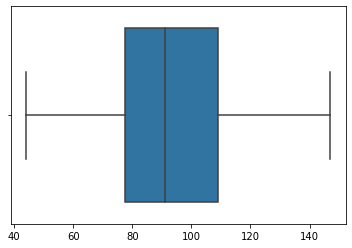


[44, 45, 45, 46, 48, 48, 49, 49, 50, 50, 51, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 56, 57, 57, 58, 58, 58, 58, 58, 58, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 67, 67, 67, 67, 68, 68, 68, 68, 69, 69, 69, 69, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 76, 76, 76, 77, 78, 79, 79, 80, 80, 81, 82, 82, 83, 83, 84, 84, 85, 85, 85, 88, 89, 89, 90, 90, 91, 94, 95, 96, 97, 97, 97, 98, 99, 99, 99, 99, 101, 101, 101, 101, 102, 103, 109, 110, 110, 111, 116, 116, 118, 122, 125, 126, 128, 128, 131, 134, 136, 142, 143, 150, 153, 155, 158, 161, 163]


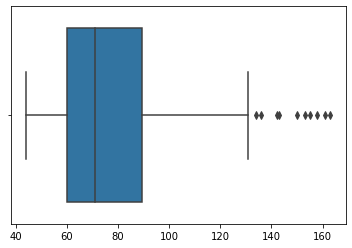


[26, 30, 31, 32, 32, 33, 36, 37, 39, 39, 39, 41, 42, 43, 45, 46, 46, 47, 47, 49, 49, 50, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 54, 54, 55, 56, 56, 57, 57, 57, 57, 57, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 63, 63, 65, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 68, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 74, 75, 75, 75, 75, 76, 77, 78, 78, 79, 79, 80, 80, 81, 81, 81, 81, 82, 82, 82, 83, 83, 83, 83, 83, 84, 84, 84, 84, 85, 85, 85, 85, 86, 86, 87, 88, 88, 89, 90, 90, 90, 90, 90, 90, 91, 91, 94, 94, 95, 96, 96, 96, 97, 98, 100, 101, 102, 102, 102, 103, 104, 105, 106, 106, 106, 107, 107, 109, 112, 113, 114, 114, 115, 116, 116, 117, 118, 162, 163]


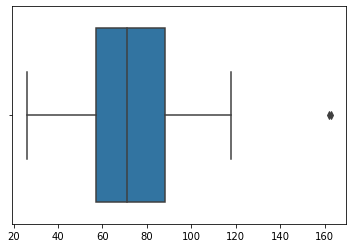


[25, 30, 30, 32, 36, 36, 37, 38, 38, 39, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 42, 43, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 47, 48, 49, 49, 49, 50, 50, 50, 51, 53, 53, 54, 54, 55, 55, 55, 55, 56, 56, 57, 57, 57, 57, 57, 58, 58, 58, 59, 59, 59, 59, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 69, 70, 70, 71, 71, 71, 72, 72, 72, 73, 74, 74, 74, 75, 75, 76, 76, 76, 76, 76, 76, 77, 77, 77, 78, 78, 79, 80, 80, 80, 81, 81, 81, 81, 81, 82, 82, 83, 84, 85, 86, 86, 88, 88, 89, 89, 90, 91, 91, 92, 92, 93, 93, 96, 96, 97, 100, 100, 101, 102, 102, 102, 102, 103, 103, 103, 104, 104, 105, 106, 106, 108, 109, 112, 119, 122, 124, 126, 127]


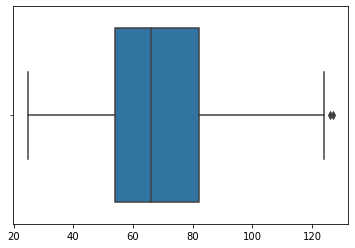


[24, 24, 26, 27, 28, 29, 29, 29, 30, 31, 31, 32, 32, 34, 35, 36, 37, 37, 38, 39, 40, 41, 41, 41, 42, 43, 44, 44, 44, 45, 46, 46, 46, 46, 47, 47, 48, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 61, 61, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 65, 66, 66, 66, 66, 67, 67, 67, 67, 68, 68, 68, 68, 69, 69, 69, 70, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 82, 82, 82, 83, 83, 83, 84, 84, 84, 85, 88, 89, 89, 89, 90, 90, 92, 92, 92, 93, 94, 94, 95, 102, 103, 106, 106, 107, 109, 115, 124, 138, 153, 155, 157, 162, 165]


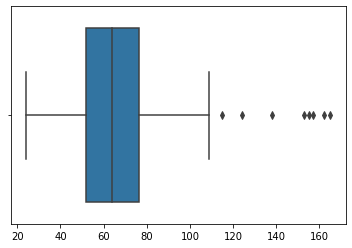


[31, 32, 33, 34, 35, 35, 36, 37, 38, 38, 38, 39, 40, 40, 41, 42, 42, 42, 42, 43, 44, 44, 45, 46, 50, 51, 51, 51, 52, 52, 52, 53, 54, 54, 55, 55, 55, 56, 56, 57, 57, 57, 57, 58, 58, 58, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 62, 62, 62, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 66, 66, 66, 67, 67, 67, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 73, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 77, 77, 77, 77, 77, 78, 78, 78, 79, 79, 79, 79, 80, 81, 81, 81, 82, 82, 82, 83, 83, 85, 85, 85, 85, 85, 87, 88, 88, 88, 88, 88, 90, 91, 92, 94, 94, 97, 97, 98, 103, 104, 104, 104, 105, 111, 112, 113, 115, 116, 118, 127, 129, 132, 137, 140, 143, 144, 144, 145, 146, 147, 151, 152, 158]


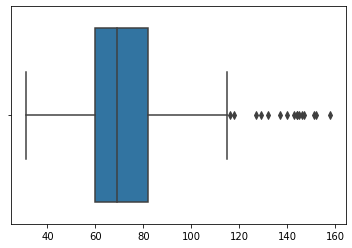


[37, 37, 39, 40, 40, 49, 49, 51, 52, 52, 53, 53, 54, 55, 55, 55, 55, 55, 55, 56, 56, 56, 57, 57, 58, 59, 60, 60, 60, 61, 61, 61, 61, 61, 61, 62, 62, 63, 63, 63, 65, 66, 66, 66, 67, 68, 70, 70, 70, 71, 71, 71, 73, 73, 73, 74, 74, 74, 74, 75, 76, 76, 77, 77, 77, 77, 78, 78, 78, 79, 80, 82, 84, 85, 85, 85, 85, 86, 87, 88, 89, 89, 89, 89, 91, 91, 92, 92, 92, 92, 93, 94, 94, 94, 94, 95, 95, 96, 96, 96, 97, 97, 97, 97, 97, 98, 98, 98, 99, 100, 100, 100, 100, 101, 101, 101, 101, 103, 104, 104, 104, 109, 110, 115, 120, 126, 127, 128, 128, 135, 137, 140, 142, 143, 149, 151, 152, 168, 169, 171, 174]


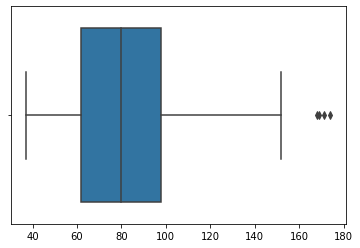


[36, 40, 42, 43, 43, 44, 45, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 51, 51, 51, 51, 51, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 56, 56, 56, 56, 56, 57, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 59, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 63, 63, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 66, 67, 67, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 75, 75, 76, 76, 76, 76, 77, 78, 78, 78, 78, 78, 79, 79, 79, 80, 80, 81, 81, 82, 83, 85, 86, 87, 87, 87, 87, 87, 87, 89, 89, 91, 91, 91, 92, 92, 92, 92, 92, 94, 94, 96, 96, 96, 98, 98, 98, 99, 103, 103, 103, 103, 104, 104, 106, 106, 108, 108, 109, 110, 110, 113, 114, 115, 115, 123, 128, 129, 132, 137, 138, 143, 149]


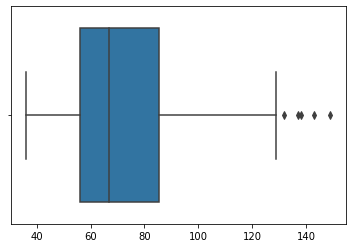

In [18]:
import utils
import seaborn as sns
import matplotlib.pyplot as plt

for index in range(9):
    batches, indexes = utils.batchify_per_sentence_with_pre_and_post_context(
                iterator_list[index], 
                1, 
                5, 
                0, 
                'bert-base-uncased', 
                max_length=512)
    print(sorted([len(item.split()) for item in batches]))
    sns.boxplot(sorted([len(item.split()) for item in batches]))
    plt.show()
    print()

116
[212, 222, 223, 223, 223, 224, 229, 231, 232, 237, 239, 240, 241, 242, 242, 243, 243, 244, 244, 244, 247, 247, 248, 248, 249, 250, 250, 254, 254, 254, 256, 256, 258, 260, 261, 261, 261, 264, 267, 267, 269, 269, 270, 271, 273, 274, 274, 275, 276, 281, 281, 284, 287, 288, 289, 290, 290, 290, 292, 292, 294, 294, 294, 294, 295, 296, 297, 298, 299, 299, 300, 302, 303, 304, 307, 308, 308, 311, 312, 312, 314, 314, 315, 317, 317, 318, 320, 322, 322, 322, 324, 326, 327, 328, 330, 330, 331, 331, 331, 332, 335, 335, 337, 337, 337, 338, 339, 339, 343, 346, 347, 348, 348, 351, 355, 357]


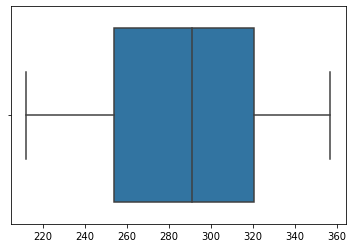


116
[240, 241, 247, 248, 261, 263, 263, 264, 267, 268, 269, 272, 272, 274, 274, 280, 283, 284, 286, 287, 290, 292, 296, 298, 300, 300, 304, 304, 305, 305, 305, 306, 308, 309, 309, 310, 311, 311, 311, 312, 312, 312, 313, 313, 313, 314, 314, 315, 315, 315, 315, 316, 316, 321, 322, 323, 324, 325, 326, 327, 330, 330, 332, 334, 334, 335, 335, 336, 338, 338, 339, 340, 340, 341, 341, 342, 343, 345, 346, 347, 347, 348, 348, 350, 350, 351, 351, 351, 353, 353, 353, 353, 354, 354, 356, 357, 358, 359, 359, 360, 361, 362, 362, 362, 362, 363, 365, 367, 367, 370, 372, 374, 379, 380, 380, 382]


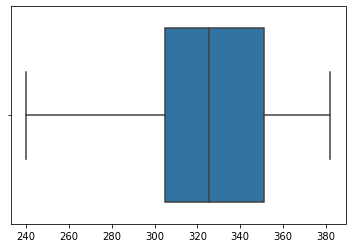


157
[185, 201, 202, 202, 204, 204, 205, 206, 207, 209, 210, 211, 211, 211, 212, 215, 215, 215, 215, 218, 219, 221, 222, 222, 223, 223, 226, 227, 227, 227, 231, 233, 237, 238, 238, 239, 239, 239, 239, 240, 241, 241, 242, 242, 242, 243, 245, 246, 248, 248, 249, 250, 251, 253, 254, 254, 259, 259, 261, 264, 264, 264, 264, 265, 266, 266, 267, 268, 268, 269, 269, 270, 274, 274, 274, 278, 279, 279, 279, 282, 282, 282, 284, 284, 285, 287, 287, 288, 289, 290, 292, 292, 295, 295, 296, 297, 298, 298, 298, 299, 301, 301, 301, 302, 302, 302, 303, 303, 303, 304, 304, 304, 305, 306, 307, 308, 308, 308, 309, 310, 310, 311, 311, 312, 312, 312, 312, 313, 313, 313, 313, 313, 314, 314, 315, 315, 316, 317, 317, 318, 318, 318, 320, 321, 322, 322, 322, 322, 323, 324, 326, 327, 328, 329, 330, 332, 332]


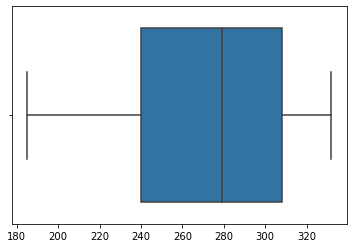


154
[177, 178, 180, 184, 184, 186, 186, 188, 192, 192, 195, 195, 196, 197, 198, 199, 200, 201, 201, 206, 209, 210, 210, 210, 211, 212, 213, 219, 219, 220, 224, 227, 228, 228, 228, 229, 229, 231, 231, 233, 233, 234, 235, 235, 235, 237, 237, 239, 241, 241, 241, 241, 242, 245, 245, 246, 246, 247, 247, 248, 248, 249, 249, 251, 251, 252, 253, 253, 254, 254, 254, 254, 256, 256, 257, 257, 260, 260, 261, 261, 261, 263, 263, 263, 264, 264, 264, 264, 265, 266, 266, 266, 266, 266, 266, 267, 267, 268, 268, 269, 272, 272, 272, 274, 274, 274, 275, 278, 279, 279, 280, 282, 283, 283, 283, 284, 284, 285, 286, 286, 286, 286, 288, 288, 290, 292, 298, 299, 301, 301, 302, 303, 305, 306, 306, 308, 309, 309, 309, 310, 312, 313, 313, 314, 314, 316, 317, 318, 318, 319, 319, 319, 320, 322]


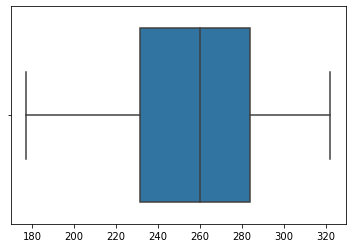


158
[168, 168, 169, 174, 180, 181, 182, 182, 183, 185, 190, 191, 192, 194, 194, 196, 196, 196, 198, 200, 201, 201, 201, 202, 204, 204, 204, 205, 205, 205, 206, 206, 206, 207, 208, 209, 209, 210, 210, 212, 213, 213, 214, 214, 215, 215, 218, 218, 220, 221, 221, 222, 223, 223, 224, 224, 224, 225, 225, 226, 226, 226, 226, 226, 227, 227, 228, 228, 228, 228, 229, 230, 230, 230, 230, 231, 231, 232, 232, 232, 233, 233, 233, 233, 233, 234, 234, 234, 235, 235, 236, 236, 236, 236, 236, 237, 237, 238, 238, 238, 239, 240, 240, 240, 240, 241, 241, 242, 242, 242, 243, 247, 251, 253, 253, 254, 255, 255, 256, 256, 259, 259, 260, 261, 261, 262, 262, 263, 263, 265, 266, 269, 273, 274, 282, 282, 287, 290, 295, 300, 305, 306, 307, 308, 315, 323, 324, 330, 331, 331, 335, 339, 341, 341, 341, 342, 347, 354]


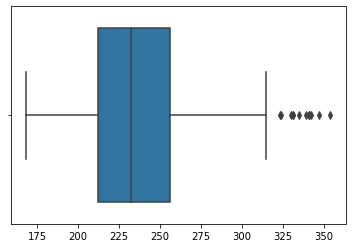


197
[109, 112, 114, 116, 130, 143, 146, 159, 164, 169, 183, 183, 184, 187, 188, 189, 190, 191, 192, 196, 196, 197, 200, 201, 202, 202, 202, 203, 203, 204, 204, 205, 205, 207, 207, 207, 207, 207, 207, 208, 208, 208, 208, 209, 209, 209, 209, 210, 211, 211, 211, 211, 213, 213, 214, 214, 214, 214, 215, 215, 215, 215, 216, 216, 216, 216, 216, 217, 217, 217, 217, 218, 218, 219, 220, 221, 222, 222, 223, 225, 225, 226, 226, 227, 227, 227, 228, 228, 228, 228, 229, 229, 230, 230, 231, 231, 231, 232, 232, 232, 233, 233, 234, 234, 234, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 236, 237, 237, 238, 238, 238, 240, 240, 240, 240, 240, 240, 241, 243, 243, 243, 246, 247, 248, 248, 248, 250, 251, 251, 251, 252, 252, 253, 254, 254, 255, 255, 255, 256, 256, 256, 257, 257, 258, 259, 263, 264, 264, 266, 268, 269, 274, 278, 279, 279, 290, 292, 295, 297, 299, 299, 300, 301, 302, 302, 305, 311, 313, 315, 328, 334, 335, 338, 339, 340, 340, 342, 343, 343, 346, 347, 347, 354, 358, 360, 390, 392]


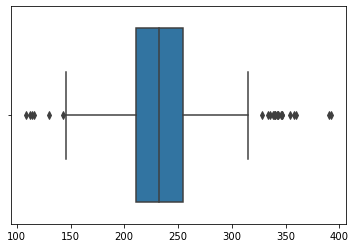


177
[165, 171, 175, 177, 178, 180, 181, 181, 181, 182, 182, 182, 183, 184, 185, 186, 187, 187, 193, 197, 198, 199, 200, 203, 203, 206, 207, 209, 209, 212, 213, 213, 214, 215, 217, 217, 217, 217, 218, 220, 221, 221, 222, 222, 223, 223, 224, 224, 225, 225, 227, 228, 228, 228, 228, 230, 231, 231, 231, 231, 233, 233, 234, 236, 236, 237, 237, 238, 238, 239, 240, 240, 241, 242, 243, 244, 245, 245, 245, 246, 248, 248, 248, 249, 251, 251, 252, 253, 253, 255, 256, 257, 258, 258, 260, 263, 263, 264, 267, 269, 271, 272, 272, 272, 273, 274, 274, 276, 277, 280, 282, 288, 288, 290, 290, 290, 292, 293, 297, 298, 298, 298, 299, 299, 300, 300, 301, 301, 301, 301, 302, 303, 305, 306, 306, 307, 307, 310, 310, 310, 311, 311, 313, 313, 313, 315, 318, 320, 320, 322, 322, 322, 323, 324, 324, 324, 326, 327, 327, 331, 334, 336, 338, 341, 342, 361, 364, 365, 365, 367, 370, 371, 373, 374, 376, 377, 379]


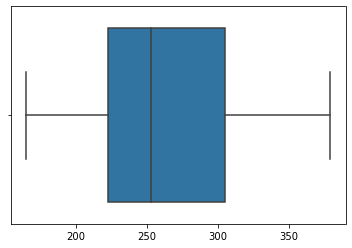


126
[183, 184, 188, 192, 204, 205, 207, 209, 210, 211, 216, 216, 219, 221, 222, 222, 223, 224, 225, 227, 228, 228, 241, 241, 243, 245, 245, 246, 249, 252, 254, 254, 254, 256, 257, 258, 259, 259, 261, 262, 264, 266, 266, 267, 269, 269, 269, 270, 272, 272, 273, 274, 279, 279, 279, 280, 281, 282, 282, 283, 284, 284, 286, 287, 289, 290, 290, 292, 293, 294, 296, 297, 298, 300, 303, 306, 309, 319, 322, 325, 327, 329, 332, 333, 333, 333, 339, 339, 341, 346, 347, 349, 349, 351, 354, 359, 359, 359, 362, 362, 363, 368, 370, 371, 371, 373, 377, 377, 379, 380, 383, 385, 386, 387, 388, 388, 389, 389, 392, 392, 393, 395, 396, 397, 398, 399]


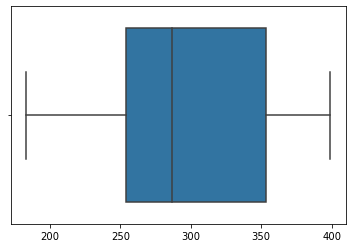


188
[173, 178, 178, 180, 182, 183, 184, 187, 189, 190, 190, 192, 192, 194, 194, 194, 194, 195, 195, 195, 196, 197, 197, 197, 197, 197, 197, 198, 198, 199, 199, 200, 200, 200, 201, 201, 201, 201, 201, 202, 202, 202, 203, 203, 203, 204, 204, 204, 205, 205, 205, 205, 206, 206, 206, 206, 206, 207, 207, 208, 208, 208, 209, 210, 210, 210, 211, 211, 211, 213, 213, 214, 215, 216, 216, 217, 218, 219, 219, 220, 221, 223, 225, 226, 227, 230, 230, 234, 234, 235, 236, 237, 239, 240, 240, 242, 243, 243, 246, 246, 247, 252, 252, 253, 254, 255, 255, 257, 259, 259, 262, 263, 265, 266, 267, 267, 269, 270, 270, 270, 271, 272, 272, 272, 272, 272, 273, 274, 274, 274, 275, 275, 275, 276, 279, 279, 280, 281, 281, 282, 282, 282, 283, 285, 287, 287, 288, 288, 289, 289, 290, 292, 292, 293, 293, 293, 294, 294, 295, 298, 298, 305, 305, 307, 309, 311, 312, 312, 313, 315, 317, 322, 327, 332, 339, 346, 346, 348, 353, 356, 357, 358, 359, 361, 370, 370, 371, 377]


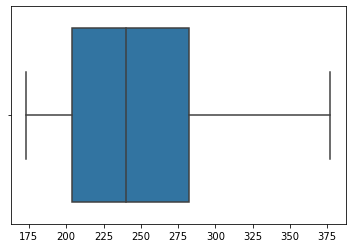

In [21]:
import utils
import seaborn as sns
import matplotlib.pyplot as plt

for index in range(9):
    batches, indexes = utils.batchify_per_sentence_with_pre_and_post_context(
                iterator_list[index], 
                1, 
                20, 
                0, 
                'bert-base-uncased', 
                max_length=512)
    print(len(batches))
    print(sorted([len(item.split()) for item in batches]))
    sns.boxplot(sorted([len(item.split()) for item in batches]))
    plt.show()
    print()

## Activation extraction

In [8]:
pretrained_bert_models = ['bert-base-uncased'] * 11
names = [
    'bert-base-uncased_test-pos_1-sent_token-0',
    'bert-base-uncased_test-pos_1-sent_token-1',
    'bert-base-uncased_test-pos_1-sent_token-2',
    'bert-base-uncased_test-pos_1-sent_token-5',
    'bert-base-uncased_test-pos_1-sent_token-7',
    'bert-base-uncased_test-pos_1-sent_token-10',
    'bert-base-uncased_test-pos_1-sent_token-15',
    'bert-base-uncased_test-pos_1-sent_token-20',
    'bert-base-uncased_test-pos_1-sent_token-30',
    'bert-base-uncased_test-pos_1-sent_token-40',
    'bert-base-uncased_test-pos_1-sent_token-1000',
         ]
config_paths = [None] * 11
saving_path_folders = [
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-0'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-1'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-2'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-5'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-7'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-10'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-15'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-20'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-30'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-40'.format(language),
    '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}/bert-base-uncased_test-pos_1-sent_token-1000'.format(language),
]
prediction_types = ['token-level'] * 11
number_of_sentence_list = [1] * 11
number_of_sentence_before_list = [0] * 11  # 0, 1, 2, 5, 7, 10,
number_of_sentence_after_list = [0] * 11
attention_length_before_list = [0, 1, 2, 5, 7, 10, 15, 20, 30, 40, 1000]
attention_length_after_list = [0] * 11 



In [ ]:
for index, bert_model in enumerate(pretrained_bert_models):
    extractor = BertExtractor(bert_model, 
                              language, 
                              names[index], 
                              prediction_types[index], 
                              output_hidden_states=True, 
                              output_attentions=True, 
                              attention_length_before=attention_length_before_list[index],
                              attention_length_after=attention_length_after_list[index],
                              config_path=config_paths[index], 
                              max_length=512, 
                              number_of_sentence=number_of_sentence_list[index], 
                              number_of_sentence_before=number_of_sentence_before_list[index], 
                              number_of_sentence_after=number_of_sentence_after_list[index],
                             )
    print(extractor.name, ' - Extracting activations ...')
    for run_index, iterator in tqdm(enumerate(iterator_list)):
        gc.collect()
        print("############# Run {} #############".format(run_index))
        activations  = extractor.extract_activations(iterator, language)
        hidden_states_activations = activations[0]
        attention_heads_activations = activations[1]
        #(cls_hidden_states_activations, cls_attention_activations) = activations[2]
        #(sep_hidden_states_activations, sep_attention_activations) = activations[3]
        activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
        #cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
        #sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)
        
        transform(
            activations, 
            saving_path_folders[index], 
            'activations', 
            run_index=run_index,
            n_layers_hidden=13,
            n_layers_attention=12, 
            hidden_size=768)
        #transform(cls_activations, saving_path_folders[index], 'cls')
        #transform(sep_activations, saving_path_folders[index], 'sep')
        
        #activations.to_csv(os.path.join(saving_path_folders[index], 'activations_run{}.csv'.format(run_index + 1)), index=False)
        #cls_activations.to_csv(os.path.join(saving_path_folders[index], 'cls_run{}.csv'.format(run_index + 1)), index=False)
        #sep_activations.to_csv(os.path.join(saving_path_folders[index], 'sep_run{}.csv'.format(run_index + 1)), index=False)
        del activations
        #del cls_activations
        #del sep_activations
        del hidden_states_activations
        del attention_heads_activations
        #del cls_hidden_states_activations
        #del cls_attention_activations
        #del sep_hidden_states_activations
        #del sep_attention_activations
        

0it [00:00, ?it/s]

bert-base-uncased_test-pos_1-sent_token-0  - Extracting activations ...
############# Run 0 #############


1it [01:10, 70.81s/it]

############# Run 1 #############


### Generate control activations

In [76]:
bert_model = 'bert-base-cased'
language = 'english'
name = 'bert-base-cased_control_'
prediction_type = 'sentence'
saving_path_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{}'.format(language)
seeds = [24, 213, 1111, 61, 183]

In [77]:
def randomize_layer(model, layer_nb):
    """Randomize layer weights and put bias to zero.
    The input "layer_nb" goes from 1 to 12 to be coherent with the rest of the analysis.
    It is then transfomed in the function.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.query.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.query.weight))
    model.encoder.layer[layer_nb].attention.self.query.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.query.bias))
    model.encoder.layer[layer_nb].attention.self.key.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.key.weight))
    model.encoder.layer[layer_nb].attention.self.key.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.key.bias))
    model.encoder.layer[layer_nb].attention.self.value.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.value.weight))
    model.encoder.layer[layer_nb].attention.self.value.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.value.bias))
    model.encoder.layer[layer_nb].attention.output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.dense.weight))
    model.encoder.layer[layer_nb].attention.output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.dense.bias))
    model.encoder.layer[layer_nb].attention.output.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.LayerNorm.weight))
    model.encoder.layer[layer_nb].attention.output.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.LayerNorm.bias))
    model.encoder.layer[layer_nb].intermediate.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].intermediate.dense.weight))
    model.encoder.layer[layer_nb].intermediate.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].intermediate.dense.bias))
    model.encoder.layer[layer_nb].output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.dense.weight))
    model.encoder.layer[layer_nb].output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.dense.bias))
    model.encoder.layer[layer_nb].output.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.LayerNorm.weight))
    model.encoder.layer[layer_nb].output.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.LayerNorm.bias))
    return model

In [78]:
def randomize_attention_query(model, layer_nb):
    """Randomize attention query weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.query.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.query.weight))
    model.encoder.layer[layer_nb].attention.self.query.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.query.bias))
    return model

def randomize_attention_key(model, layer_nb):
    """Randomize attention key weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.key.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.key.weight))
    model.encoder.layer[layer_nb].attention.self.key.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.key.bias))
    return model

def randomize_attention_value(model, layer_nb):
    """Randomize attention value weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.self.value.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.self.value.weight))
    model.encoder.layer[layer_nb].attention.self.value.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.self.value.bias))
    return model

def randomize_attention_output_dense(model, layer_nb):
    """Randomize attention dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].attention.output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].attention.output.dense.weight))
    model.encoder.layer[layer_nb].attention.output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].attention.output.dense.bias))
    return model


def randomize_intermediate_dense(model, layer_nb):
    """Randomize intermediate dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].intermediate.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].intermediate.dense.weight))
    model.encoder.layer[layer_nb].intermediate.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].intermediate.dense.bias))
    return model

def randomize_outptut_dense(model, layer_nb):
    """Randomize output dense network weights of a given layer and put bias to zero.
    """
    layer_nb = layer_nb - 1
    model.encoder.layer[layer_nb].output.dense.weight = torch.nn.parameter.Parameter(torch.rand_like(model.encoder.layer[layer_nb].output.dense.weight))
    model.encoder.layer[layer_nb].output.dense.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.encoder.layer[layer_nb].output.dense.bias))
    return model


In [79]:
def randomize_embeddings(model):
    """Randomize embeddings weights and put bias to zero.
    """
    model.embeddings.word_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.word_embeddings.weight))
    model.embeddings.position_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.position_embeddings.weight))
    model.embeddings.token_type_embeddings.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.token_type_embeddings.weight))
    model.embeddings.LayerNorm.weight = torch.nn.parameter.Parameter(torch.rand_like(model.embeddings.LayerNorm.weight))
    model.embeddings.LayerNorm.bias = torch.nn.parameter.Parameter(torch.zeros_like(model.embeddings.LayerNorm.bias))
    return model

In [80]:
for seed in seeds:
    set_seed(seed)
    for layer in range(13):
        extractor = BertExtractor(bert_model, language, name, prediction_type, output_hidden_states=True, output_attentions=True, config_path=None)
        if layer==0:
            extractor.model = randomize_embeddings(extractor.model)
        else:
            extractor.model = randomize_layer(extractor.model, layer)
        print(extractor.name + str(seed), ' - Extracting activations for layer {}...'.format(layer))
        for run_index, iterator in tqdm(enumerate(iterator_list)):
            print("############# Run {} #############".format(run_index))
            activations  = extractor.extract_activations(iterator, language)
            hidden_states_activations = activations[0]
            attention_heads_activations = activations[1]
            (cls_hidden_states_activations, cls_attention_activations) = activations[2]
            (sep_hidden_states_activations, sep_attention_activations) = activations[3]
            activations = pd.concat([hidden_states_activations, attention_heads_activations], axis=1)
            cls_activations = pd.concat([cls_hidden_states_activations, cls_attention_activations], axis=1)
            sep_activations = pd.concat([sep_hidden_states_activations, sep_attention_activations], axis=1)

            # activations
            heads = np.arange(1, 13)
            columns_to_retrieve = ['hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            activations = activations[columns_to_retrieve]

            # CLS
            heads = np.arange(1, 13)
            columns_to_retrieve = ['CLS-hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['CLS-attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            cls_activations = cls_activations[columns_to_retrieve]

            # SEP
            heads = np.arange(1, 13)
            columns_to_retrieve = ['SEP-hidden_state-layer-{}-{}'.format(layer, i) for i in range(1, 769)]
            if layer > 0:
                columns_to_retrieve += ['SEP-attention-layer-{}-head-{}-{}'.format(layer, head, i) for head in heads for i in range(1, 65)]
            sep_activations = sep_activations[columns_to_retrieve]

            save_path = os.path.join(saving_path_folder, name + str(seed) + '_layer-{}'.format(layer))
            check_folder(save_path)
            print('\tSaving in {}.'.format(save_path))
            activations.to_csv(os.path.join(save_path, 'activations_run{}.csv'.format(run_index + 1)), index=False)
            cls_activations.to_csv(os.path.join(save_path, 'cls_run{}.csv'.format(run_index + 1)), index=False)
            sep_activations.to_csv(os.path.join(save_path, 'sep_run{}.csv'.format(run_index + 1)), index=False)


0it [00:00, ?it/s]

bert-base-cased  - Extracting activations for layer 0...
############# Run 0 #############


1it [00:23, 23.37s/it]

############# Run 1 #############


2it [00:50, 24.54s/it]

############# Run 2 #############


3it [01:23, 26.94s/it]

############# Run 3 #############


3it [01:44, 34.92s/it]


KeyboardInterrupt: 